In [2]:
import numpy as np
import os
from src.run_model import run_model
from src.my_dataset import MyDataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

try:
    import matplotlib.pyplot as plt
except:
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

base = '/Users/jacobwit/Documents/GitHub/CS-349/final-project'
data_path = os.path.join(base, 'YearPredictionMSD.txt')
all_data = np.loadtxt(data_path, delimiter=',')
print(np.shape(all_data))

(515345, 91)


In [3]:
train_years = all_data[:463715, 0]
test_years = all_data[463715:, 0]
train_attributes = all_data[:463715, 1:]
test_attributes = all_data[463715:, 1:]
values = np.unique(all_data[:,0])


In [4]:
# Kmeans experiment
kmeans_fitter = KMeans(n_clusters=89).fit(train_attributes)
k_a = kmeans_fitter.predict(test_attributes)
k_means_clusters = {}
for i in range(k_a.shape[0]):
    actual_year = test_years[i]
    given_label = k_a[i]
    if given_label in k_means_clusters:
        k_means_clusters[given_label].append(actual_year)
    else:
        k_means_clusters[given_label] = [actual_year]
for cluster in k_means_clusters:
    k_means_clusters[cluster] = np.array(k_means_clusters[cluster])

total_correct = 0
total = 0
within_3_years = 0
for cluster in k_means_clusters:
    values, counts = np.unique(k_means_clusters[cluster], return_counts=True)
    most_common_value = values[np.argmax(counts)]
    for i in range(k_means_clusters[cluster].shape[0]):
        if k_means_clusters[cluster][i] == most_common_value:
            total_correct += 1
            within_3_years += 1
        elif np.abs((most_common_value - k_means_clusters[cluster][i])) <= 3:
            within_3_years += 1
        total += 1
print("Kmeans accuracy")
print(total_correct / total)
print("Within 3 years accuracy")
print(within_3_years / total)

Kmeans accuracy
0.08543482471431338
Within 3 years accuracy
0.4165020337013364


In [5]:
## decades experiment
train_decades = np.zeros(train_years.shape[0])
for i in range(train_years.shape[0]):
    current_year = train_years[i]
    if current_year <= 1929:
        train_decades[i] = 1
    elif current_year <= 1939:
        train_decades[i] = 2
    elif current_year <= 1949:
        train_decades[i] = 3
    elif current_year <= 1959:
        train_decades[i] = 4
    elif current_year <= 1969:
        train_decades[i] = 5
    elif current_year <= 1979:
        train_decades[i] = 6
    elif current_year <= 1989:
        train_decades[i] = 7
    elif current_year <= 1999:
        train_decades[i] = 8
    elif current_year <= 2009:
        train_decades[i] = 9
    else:
        train_decades[i] = 10

test_decades = np.zeros(test_years.shape[0])
for i in range(test_years.shape[0]):
    current_year = train_years[i]
    if current_year <= 1929:
        test_decades[i] = 1
    elif current_year <= 1939:
        test_decades[i] = 2
    elif current_year <= 1949:
        test_decades[i] = 3
    elif current_year <= 1959:
        test_decades[i] = 4
    elif current_year <= 1969:
        test_decades[i] = 5
    elif current_year <= 1979:
        test_decades[i] = 6
    elif current_year <= 1989:
        test_decades[i] = 7
    elif current_year <= 1999:
        test_decades[i] = 8
    elif current_year <= 2009:
        test_decades[i] = 9
    else:
        test_decades[i] = 10

kmeans_decades_fitter = KMeans(n_clusters=10).fit(train_attributes)
decade_predictions = kmeans_decades_fitter.predict(test_attributes)

k_means_decades_clusters = {}
for i in range(decade_predictions.shape[0]):
    actual_decade = test_decades[i]
    given_label = decade_predictions[i]
    if given_label in k_means_decades_clusters:
        k_means_decades_clusters[given_label].append(actual_decade)
    else:
        k_means_decades_clusters[given_label] = [actual_decade]
for cluster in k_means_decades_clusters:
    k_means_decades_clusters[cluster] = np.array(k_means_decades_clusters[cluster])

total_correct = 0
total = 0

for cluster in k_means_decades_clusters:
    values, counts = np.unique(k_means_decades_clusters[cluster], return_counts=True)
    most_common_value = values[np.argmax(counts)]
    for i in range(k_means_decades_clusters[cluster].shape[0]):
        if k_means_decades_clusters[cluster][i] == most_common_value:
            total_correct += 1
        total += 1
print("Kmeans decade accuracy")
print(total_correct / total)


Kmeans decade accuracy
0.5807476273484409


In [6]:
#changing means experiments
num_means = np.array([2, 3, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80])
accuracies = []

for i in range(num_means.shape[0]):
    means = num_means[i]
    #reclassified_train_years = np.floor(((train_years - 1922) / (89 / means)))
    reclassified_train_years = np.floor(train_years - 1922)
    factor = 89 / means
    reclassified_train_years = np.floor(reclassified_train_years / factor)
    reclassified_test_years = test_years - 1922
    reclassified_test_years = np.floor(reclassified_test_years / factor)
    classifier = KMeans(n_clusters=means).fit(train_attributes)
    predictions = classifier.predict(test_attributes)
    clusters = {}
    for j in range(predictions.shape[0]):
        actual_class = reclassified_test_years[j]
        given_class = predictions[j]
        if given_class in clusters:
            clusters[given_class].append(actual_class)
        else:
            clusters[given_class] = [actual_class]
    for cluster in clusters:
        clusters[cluster] = np.array(clusters[cluster])

    correct = 0
    total = 0
    for cluster in clusters:
        values, counts = np.unique(clusters[cluster], return_counts=True)
        most_common_cluster = values[np.argmax(counts)]
        for k in range(clusters[cluster].shape[0]):
            if clusters[cluster][k] == most_common_cluster:
                correct += 1
            total += 1
    accuracy = correct / total
    accuracies.append(accuracy)







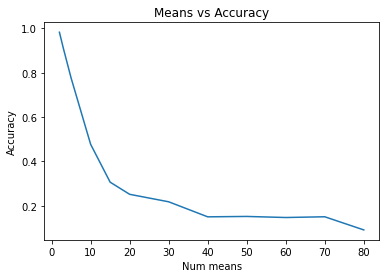

In [7]:
accuracies = np.array(accuracies)
plt.plot(num_means, accuracies)
plt.xlabel('Num means')
plt.ylabel('Accuracy')
plt.title('Means vs Accuracy')
plt.show()